In [1]:
import numpy as onp
import jax.numpy as np
from jax import random, vmap
from jax.config import config
config.update("jax_enable_x64", True)

from scipy.optimize import minimize
from scipy import stats
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.interpolate import griddata

from jaxbo.models import GP
from jaxbo.utils import normalize

import jaxbo.acquisitions as acquisitions
import jaxbo.utils as utils
from jaxbo.input_priors import uniform_prior

from sklearn import mixture
from pyDOE import lhs

onp.random.seed(1234)


In [2]:
def wheel_function(x, y, delta_control):
    # define the control parameter
    reward0 = 0.2
    reward1 = 1.0
    reward2 = 0.1
    reward3 = 0.05
    reward4 = 0.0
    
    # the number of modes in this direction
    r = np.sqrt(x**2 + y**2)
    if r < delta_control:
        return reward0
    elif (x >= 0) & (y >= 0):
        return reward1
    elif (x >= 0) & (y <= 0):
        return reward2
    elif (x <= 0) & (y >= 0):
        return reward3
    else:
        return reward4


In [3]:
class run_simulations:
    # Initialize the class
    def __init__(self, data_test, xs_in, sigma_in, T_in, MC_samples_in, XX, YY, Y_data_plot, nn, delta_control):
        
        # Initialize the model
        self.Data = data_test
        self.N_dim = self.Data.shape[0]
        
        self.xs = xs_in
        self.xs_plot = onp.asarray(xs_in)
        self.sigma = sigma_in
        self.T = T_in
        self.MC_samples = MC_samples_in
        self.delta = 0.1
        self.jitter = 1e-8
        self.N_init = 3
        
        self.XX = XX
        self.YY = YY
        self.Y_data_plot = Y_data_plot
        self.nn = nn
        self.delta_control = delta_control
        
        # define GP model and JAX GP options
        self.dim = xs_in.shape[1]
        self.lb = 0.0*np.ones(self.dim)
        self.ub = 1.0*np.ones(self.dim)
        self.bounds = {'lb': self.lb, 'ub': self.ub}
        self.p_x = uniform_prior(self.lb, self.ub)
        self.options = {'kernel': 'RBF', 'input_prior': self.p_x}
        self.gp_model = GP(self.options)
        
        self.rng_key = random.PRNGKey(0)
        
        
    # Different types of acquisition functions
    def acquisition_functions(self, mu, std, y_sample, best, beta = 1.0, weights = 0, method = "LCB"):
        kappa = 2.0
        if method == "LCB":
            return vmap(acquisitions.LCB, in_axes=(0,0,None))(mu[:,None], std[:,None], np.sqrt(beta))
        if method == "LCB_v":
            return vmap(acquisitions.LCB, in_axes=(0,0,None))(mu[:,None], std[:,None], kappa)
        if method == "mean":
            return mu
        if method == "LW_LCB":
            return vmap(acquisitions.LW_LCB, in_axes=(0,0,0,None))(mu[:,None], std[:,None], weights[:,None], kappa)
        if method == "TS":
            return y_sample
        if method == "EI":
            return vmap(acquisitions.EI, in_axes=(0,0,None))(mu[:,None], std[:,None], best)
    
    
    def compute_weights(self, x):
        
        weights = utils.compute_w_gmm(x, **self.kwargs)
        self.weights = weights
        
        return weights
        
    def compute_beta(self, t):
        beta = 2 * np.log(t**2*np.pi**2/(6 * self.delta))
        beta = beta / 5.
        return beta

    def compute_mu_std_sample(self, X, y, X_star, rng_key, compute_weight = False):
        
        # Fetch normalized training data
        norm_batch, norm_const = normalize(X, y, self.bounds)

        # Train GP model
        opt_params = self.gp_model.train(norm_batch, rng_key, num_restarts = 10)
        
        # Define the dictionary to feed in the GP regression 
        self.kwargs = {'params': opt_params, 
                  'batch': norm_batch, 
                  'norm_const': norm_const, 
                  'bounds': self.bounds,
                  'rng_key': rng_key}
        
        if compute_weight:
            gmm_vars = self.gp_model.fit_gmm(**self.kwargs, num_comp = 4, N_samples = 10000)

            self.kwargs = {'params': opt_params,
                  'batch': norm_batch,
                  'norm_const': norm_const,
                  'bounds': self.bounds,
                  'gmm_vars': gmm_vars,
                  'rng_key': rng_key}

        # Draw posterior mean and std and a sample from posterior distribution 
        mu, std = self.gp_model.predict(X_star, **self.kwargs)
        y_sample = self.gp_model.draw_posterior_sample(X_star, **self.kwargs)
        
        mu, std = mu * norm_const['sigma_y'] + norm_const['mu_y'], std *norm_const['sigma_y']
        y_sample = y_sample * norm_const['sigma_y'] + norm_const['mu_y']
        
        return mu, std, y_sample
        
        
    def run_one_trial(self, sample_idx, method = "LCB"):
        
        # the testing data for the current MC trial
        data = self.Data[:,sample_idx]
        x_cand = self.xs
        
        # inital random observation
        idx_cand = np.arange(x_cand.shape[0])
        idx_valid_init = idx_cand[(np.sqrt(np.sum(x_cand**2, axis = 1)) <= self.delta_control)]
        idx_init = idx_valid_init[onp.random.randint(idx_valid_init.shape[0], size = self.N_init)]
        
        print(idx_init)
        #idx_init = list(onp.random.randint(self.N_dim, size = self.N_init)) 
        
        # check the shape (Y is vector not array)
        Y = data[idx_init] + onp.random.normal(0, self.sigma, self.N_init)
        X = x_cand[idx_init,:]
        
        regrets = []
        
        # get the best payoff
        index_best = np.argmin(data)
        Y_best = data[index_best]
        
        # start to record the regret
        regrets.append(abs(Y_best - np.min(Y)))
        
        rng_key = random.split(self.rng_key)[0]
        # start the active learning
        for t in range(1, self.T):

            # compute beta and modify correspondingly according to inital number of data
            beta = self.compute_beta(t + self.N_init - 1)
            
            #print("X, Y", X.shape, Y.shape, X, Y)
            
            if method == "LW_LCB":
                compute_weight = True
            else:
                compute_weight = False
            
            # compute GP posterior mean and std
            rng_key = random.split(rng_key)[0]
            mu, std, y_sample = self.compute_mu_std_sample(X, Y, self.xs, rng_key, compute_weight)
            
            # best for the EI if needed
            best = np.min(Y)
            
            # compute the weight for the LW-LCB if needed
            if method == "LW_LCB":
                weights = self.compute_weights(x_cand)
            else:
                weights = 0
                
            # compute acquisition function
            acquisition_fun = self.acquisition_functions(mu, std, y_sample, best, beta, weights, method)

            # find the index best location to explore 
            best_index = np.argmin(acquisition_fun)
            
            # find the best location to explore
            X_new = x_cand[best_index:best_index+1,:]
            
            # observe the noisy reward
            Y_new = data[best_index] + onp.random.normal(0, self.sigma, 1)
            
            #print(X.shape, Y.shape, X_new.shape, Y_new.shape)
            # update X and Y
            X = np.concatenate([X, X_new], axis = 0)
            Y = np.concatenate([Y, Y_new], axis = 0)
            
            regrets.append(abs(Y_best - Y_new[0]))
            #regrets.append(abs(Y_best - min(Y)))
            
            if t == self.T - 1 and method == "LW_LCB":
                
                weights_plot = griddata((self.xs_plot[:,0], self.xs_plot[:,1]), onp.asarray(weights).flatten(), (self.XX, self.YY), method='linear')

                plt.figure(t + sample_idx, figsize = (10, 5))
                plt.subplot(1, 2, 1)
                fig = plt.contourf(self.XX, self.YY, self.Y_data_plot)
                plt.plot(X[:,0], X[:,1], 'r.', ms = 6, alpha = 0.8)
                plt.xlabel(r'$x_1$')
                plt.ylabel(r'$x_2$')
                #plt.axis('square')
                
                
                plt.subplot(1, 2, 2)
                fig = plt.contourf(self.XX, self.YY, weights_plot)
                plt.plot(X[:,0], X[:,1], 'r.', ms = 6, alpha = 0.8)
                plt.xlabel(r'$x_1$')
                plt.ylabel(r'$x_2$')
                #plt.axis('square')
                plt.show()
                
            if method == "LW_LCB":
                continue
            else:
                weights_plot = None
            
        return regrets, X, weights_plot
        
    def train(self):
        
        regrets_LCB = []
        regrets_LCB_v = []
        regrets_mean = []
        regrets_TS = []
        regrets_EI = []
        regrets_LW_LCB = []
        
        X_LCB = []
        X_LCB_v = []
        X_mean = []
        X_TS = []
        X_EI = []
        X_LW_LCB = []
        
        Weights_LW_LCB = []


        for k in range(self.MC_samples):
            if k % 1 == 0:
                print(k)
            regrets, X, weights_plot = self.run_one_trial(k, method = "LW_LCB")
            regrets_LW_LCB.append(regrets)
            X_LW_LCB.append(X)
            Weights_LW_LCB.append(weights_plot)
            regrets, X, _ = self.run_one_trial(k, method = "LCB")
            regrets_LCB.append(regrets)
            X_LCB.append(X)
            regrets, X, _ = self.run_one_trial(k, method = "LCB_v")
            regrets_LCB_v.append(regrets)
            X_LCB_v.append(X)
            regrets, X, _ = self.run_one_trial(k, method = "mean")
            regrets_mean.append(regrets)
            X_mean.append(X)
            regrets, X, _ = self.run_one_trial(k, method = "TS")
            regrets_TS.append(regrets)
            X_TS.append(X)
            regrets, X, _ = self.run_one_trial(k, method = "EI")
            regrets_EI.append(regrets)
            X_EI.append(X)

            
            
        regrets_LCB = np.asarray(regrets_LCB)
        regrets_LCB_v = np.asarray(regrets_LCB_v)
        regrets_mean = np.asarray(regrets_mean)
        regrets_TS = np.asarray(regrets_TS)
        regrets_EI = np.asarray(regrets_EI)
        regrets_LW_LCB = np.asarray(regrets_LW_LCB)
        
        X_LCB = np.asarray(X_LCB)
        X_LCB_v = np.asarray(X_LCB_v)
        X_mean = np.asarray(X_mean)
        X_TS = np.asarray(X_TS)
        X_EI = np.asarray(X_EI)
        X_LW_LCB = np.asarray(X_LW_LCB)
        
        Weights_LW_LCB = np.asarray(Weights_LW_LCB)
        
        print(regrets_LCB.shape, regrets_LCB_v.shape, regrets_mean.shape, regrets_TS.shape, regrets_EI.shape, regrets_LW_LCB.shape, \
                X_LCB.shape, X_LCB_v.shape, X_mean.shape, X_TS.shape, X_EI.shape, X_LW_LCB.shape, Weights_LW_LCB.shape)
        
        return regrets_LCB, regrets_LCB_v, regrets_mean, regrets_TS, regrets_EI, regrets_LW_LCB, \
                X_LCB, X_LCB_v, X_mean, X_TS, X_EI, X_LW_LCB, Weights_LW_LCB
            



(2724, 100)


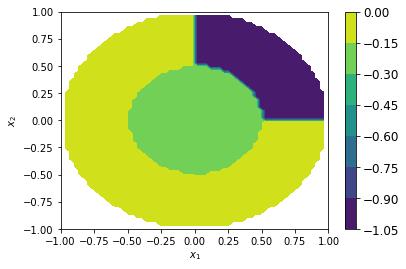

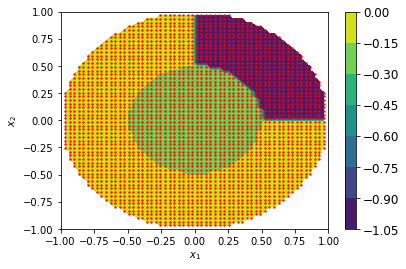

In [4]:
MC_samples = 100
nn = 60
delta_control = 0.5

# Locations for bandits
xx = onp.linspace(-1, 1, nn)
yy = onp.linspace(-1, 1, nn)
XX, YY = onp.meshgrid(xx, yy)
X_positions = onp.concatenate([XX.flatten()[:,None], YY.flatten()[:,None]], axis = 1)

# find the valid locations
R = onp.sqrt(X_positions[:,0]**2 + X_positions[:,1]**2)
X_positions = X_positions[R <= 1]

# Draw training data from functions
Y_data = onp.ones((X_positions.shape[0], 1))
for k in range(X_positions.shape[0]):
    Y_data[k, 0] = wheel_function(X_positions[k,0], X_positions[k,1], delta_control)


# Normalize the data
#Y_data = (Y_data - np.mean(Y_data)) / np.std(Y_data)

Y_data = onp.tile(Y_data,(1, MC_samples))
Y_data = -Y_data
print(Y_data.shape)


xs = X_positions

sigma = np.sqrt(1e-6) 
T = 100

# Plot the first snapshot as the data
Y_data_plot = griddata((X_positions[:,0], X_positions[:,1]), Y_data[:,0], (XX, YY), method='linear')


plt.figure(-2, figsize = (6, 4))
fig = plt.contourf(XX, YY, Y_data_plot)
plt.colorbar().ax.tick_params(labelsize=12)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
#plt.axis('square')

plt.figure(-1, figsize = (6, 4))
fig = plt.contourf(XX, YY, Y_data_plot)
plt.plot(X_positions[:,0], X_positions[:,1], 'r.', ms = 3, alpha = 0.8)
plt.colorbar().ax.tick_params(labelsize=12)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
#plt.axis('square')


Y_data = np.asarray(Y_data)
xs = np.asarray(xs)


In [5]:
#print(xs.shape)

#idx_cand = np.arange(xs.shape[0])
#print(idx_cand)
#idx_valid_init = idx_cand[(np.sqrt(np.sum(xs**2, axis = 1)) <= 0.5)]
#print(idx_valid_init)

#idx_init = idx_valid_init[list(onp.random.randint(idx_valid_init.shape[0], size = 3))]


#print(idx_init)
#print(xs[idx_init])

0
[1270  749 1093]


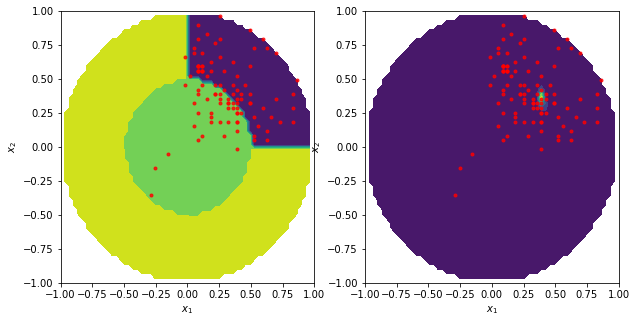

[ 644 1674 1959]
[1392 1745  932]
[1969 1900 1635]
[2025 1732 1029]
[ 974 1281 1034]
1
[1215 1614  700]


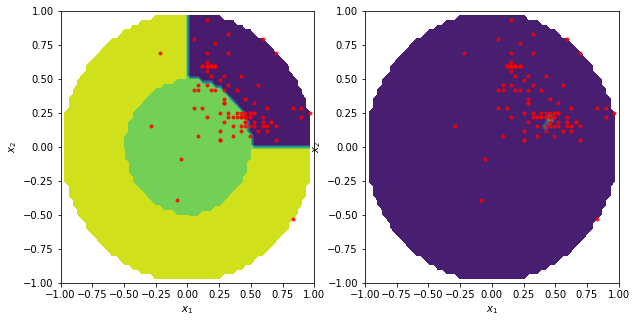

[1578 1570 1899]
[1619  701 2067]
[1459 1392 1502]
[1329 1865 1214]
[1796 1092 1459]
2
[ 656 1802 1159]


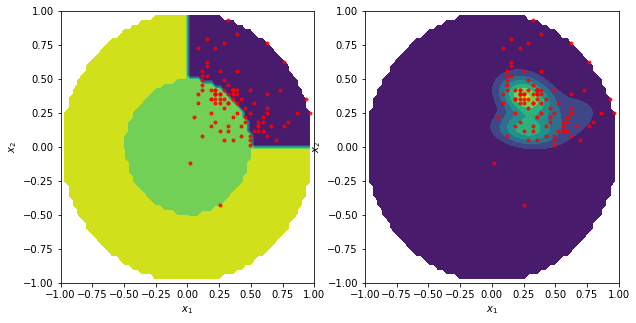

[1907 2027 1155]
[1398 1901 1858]
[1855 1791 1691]
[1631 2028 1377]
[ 859 1508  811]
3
[1046  987 1521]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


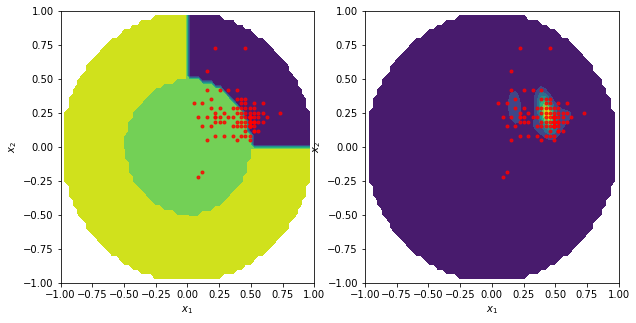

[1445 1899  654]
[1803 1038 1802]
[ 651 1221  980]
[1217 1153  591]
[1047 1053 1156]
4
[1089  767 1503]


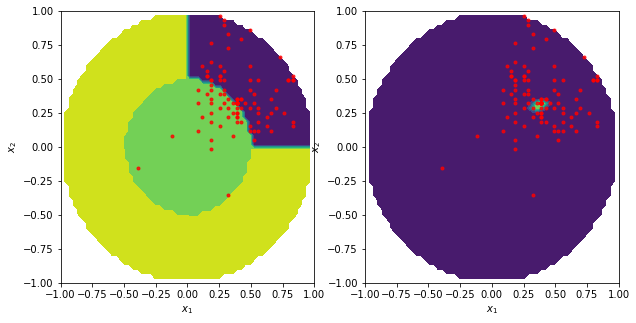

[1036 1053  767]
[1051 1341 1843]
[1507 1747 1053]
[ 809  643 1457]
[1578  805  766]
5
[2070 1163  876]


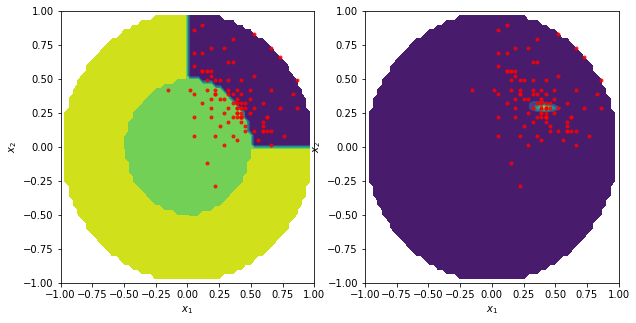

[1750 1268 1727]
[1850 2028 1509]
[1332 1688 1041]
[1230  544  694]
[1858 1383 1405]
6
[1636  760 1733]


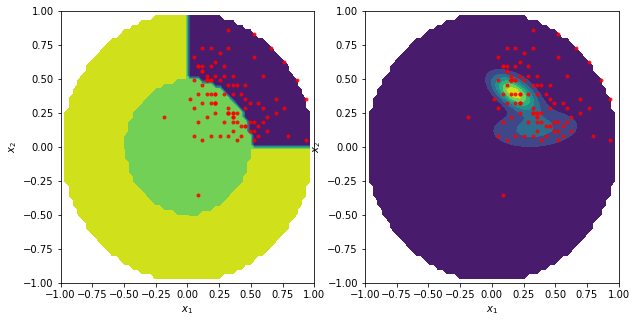

[1672 1732 1336]
[ 992 1149 1520]
[2073 2027 2028]
[2073  764  822]
[1800 1329 1847]
7
[1623 1681 1793]


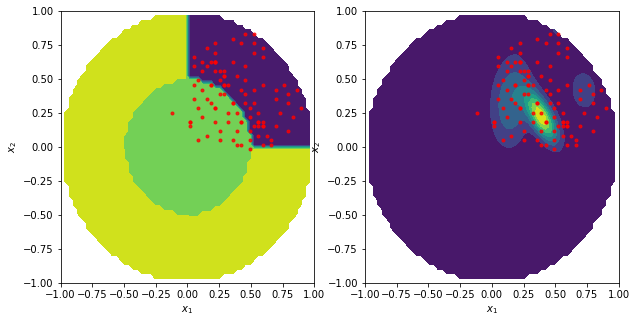

[ 877 1620 1842]
[ 939  934 1044]
[1225 1727  808]
[1436 1382 1378]
[1619 1391 1629]
8
[1518 1038 1624]


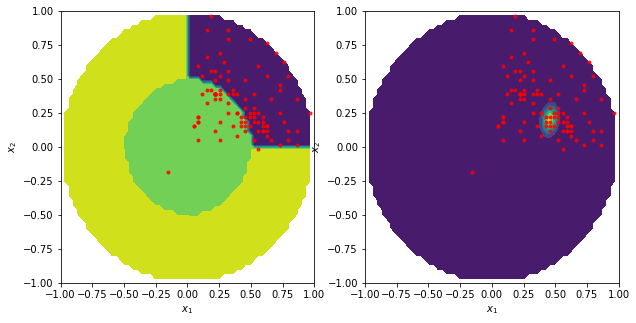

[1680 1283 1172]
[1035 1628 1392]
[ 598 1440 1149]
[1266 1673 2129]
[1628 1744 1441]
9
[1171 2067 1519]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


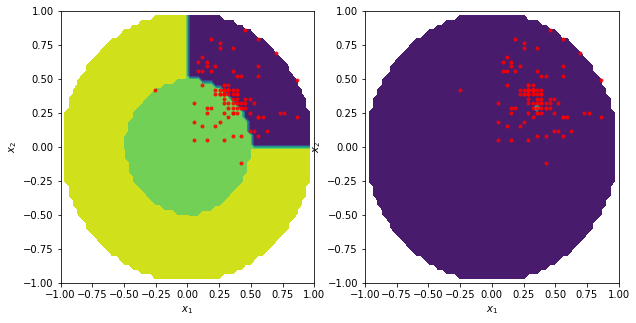

[1441 2029  808]
[1912 1556 1285]
[1051 1147 1376]
[1803 1281  983]
[ 806 1556  935]
10
[ 809  597 2024]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


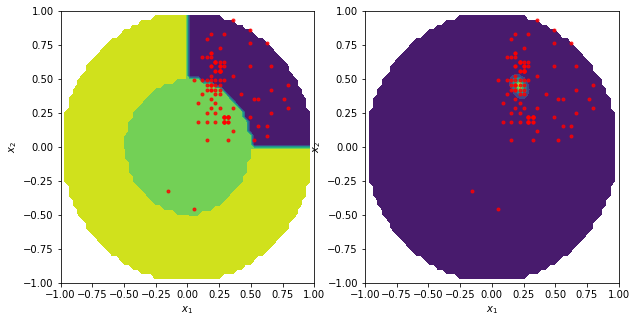

[1911 1917  872]
[ 874 1223 1339]
[1743  708  924]
[1272 1672 1910]
[1335 1733 1970]
11
[ 814 1225 1681]


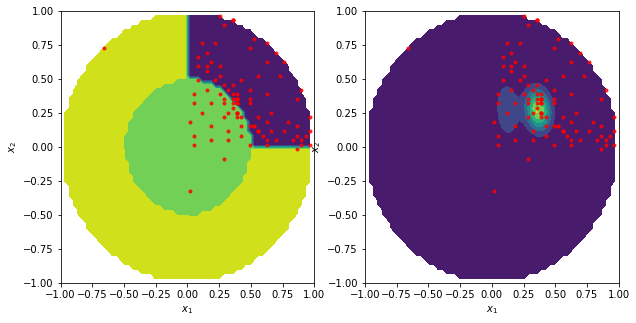

[1958 1046  867]
[1576 1624 1629]
[2077 1750 1265]
[1148 1204 1345]
[1161 1336 1318]
12
[2130  699  651]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


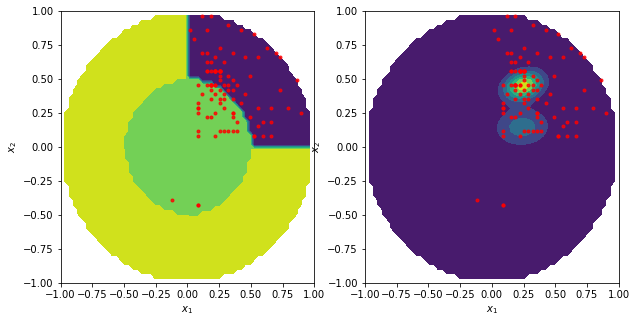

[1386 1803 1159]
[1043 1109  926]
[1094 1204 1793]
[1280  981 1694]
[ 972  821 1214]
13
[643 915 542]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


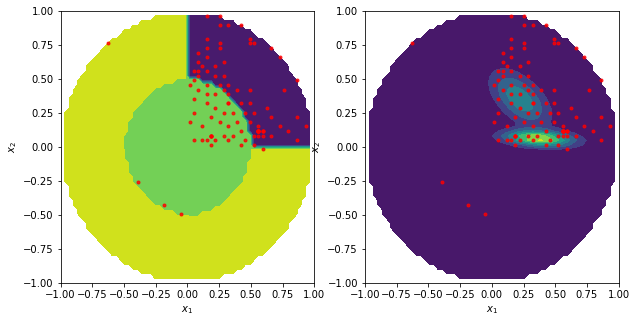

[1225 2182  981]
[1963  873 1688]
[2079 1166 1568]
[1794 1207 2020]
[1632  656  754]
14
[1747 1157 1958]


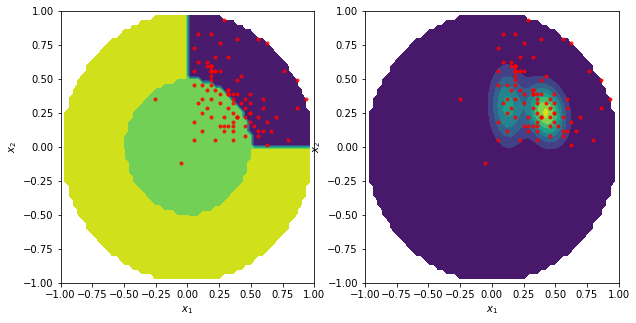

[2028 1796  711]
[1974 1735 1731]
[ 876 1050 1448]
[ 764 1042 2124]
[1321 1319 1463]
15
[ 923 1093 1206]


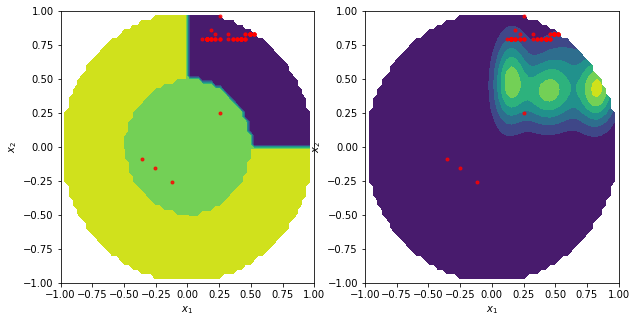

[ 766  989 1048]
[1668 1396  993]
[1219 2081  756]
[ 594  921 1511]
[1799 1785 1844]
16
[1440  879 1961]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


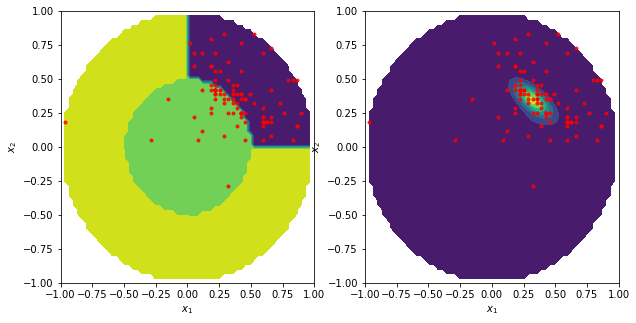

[ 760 1039  881]
[1859 1261 1029]
[2015 2080 1263]
[1343 1324 1862]
[1861  980 1516]
17
[ 989 1751 1391]


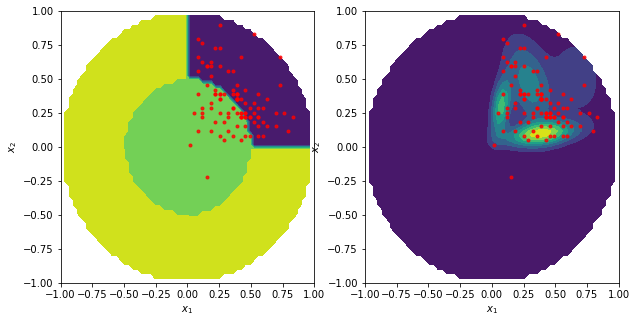

[ 862 1629 1747]
[1509  748  994]
[1203  703 1975]
[1730  861 1342]
[1565 1736  647]
18
[1789  873  754]


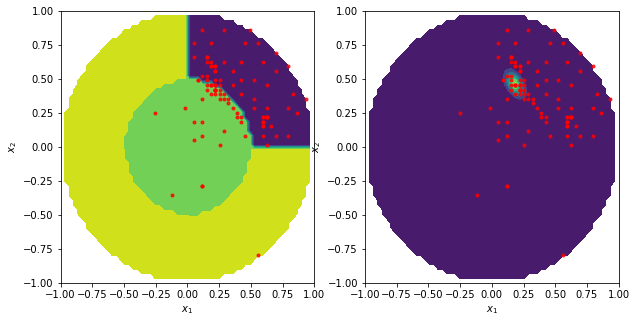

[1672 1672 1800]
[1573 2023 2182]
[1166 1804  642]
[2080 1275 1518]
[1344  860 1031]
19
[1577 1094  982]


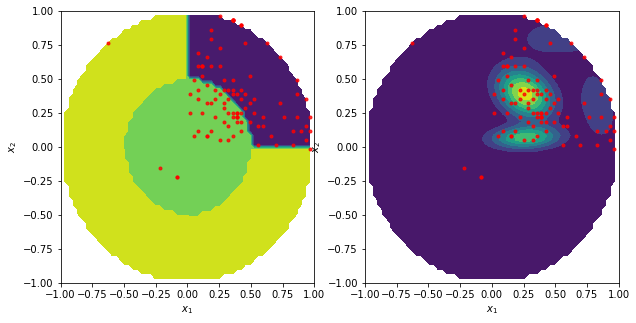

[1403  978 1347]
[1680 1502 1959]
[ 921 1458  859]
[2081 1055 1207]
[ 935 1151 1568]
20
[1551 1904 1495]


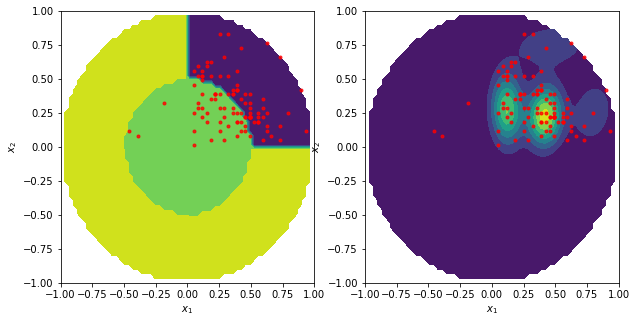

[ 814 1331 1683]
[1088 1857 1033]
[1614 1555  867]
[ 760 1158  748]
[1751 1671 1345]
21
[1566 1553 2180]


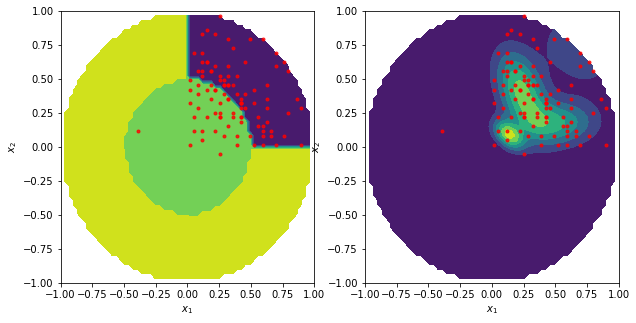

[1056  545 1227]
[1795  592 1693]
[1864 1098 1381]
[ 698 1729 1397]
[ 543  974 1346]
22
[1618  543 1402]


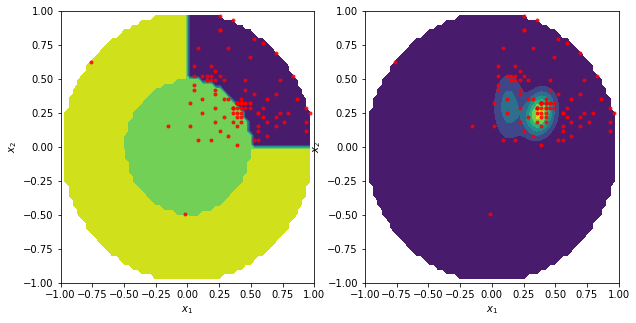

[ 920 1973 1343]
[989 645 997]
[ 757 2127 1910]
[1462 1383 2078]
[2013  653 1165]
23
[1503 1860  763]


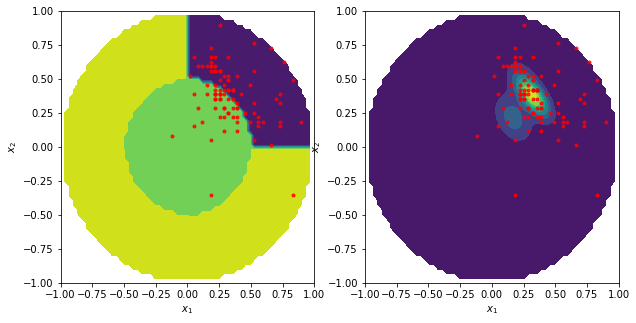

[1030 1267 1436]
[1456 1376  870]
[ 817 1679 1401]
[1919 2178 1694]
[1104 1686 1321]
24
[807 699 648]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


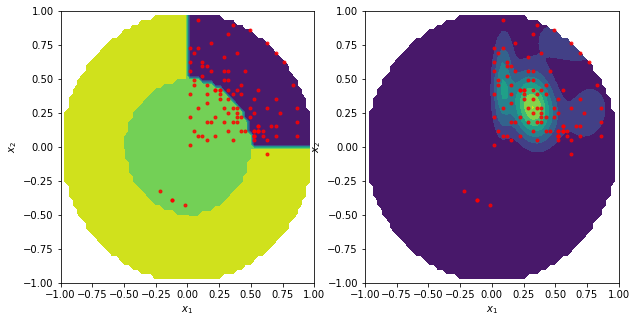

[2129 1088  600]
[1388 1729 1327]
[1388 1913 1969]
[1960 2179 1902]
[1613 1114 1093]
25
[1521 2080  761]


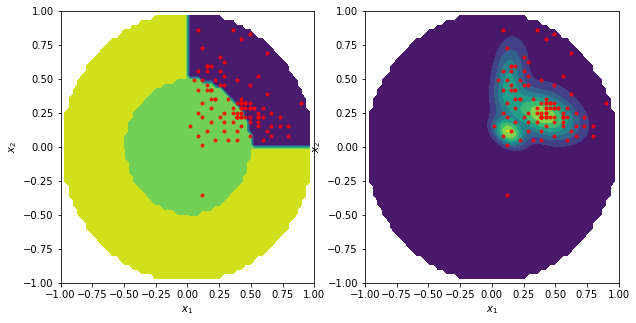

[1088  866 1684]
[1165  646  858]
[1111  935 1112]
[1510  650 1844]
[ 929  924 1916]
26
[1972 1324 1386]


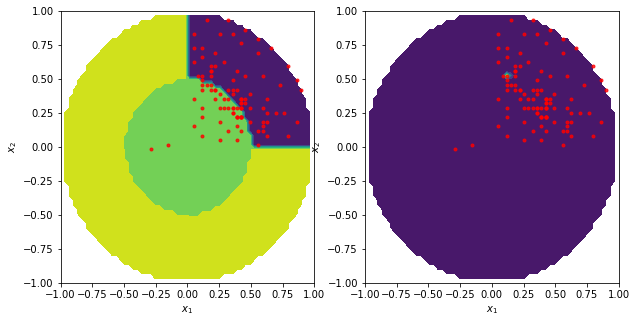

[ 822 1333 1404]
[2075  927 1159]
[ 810  702 1960]
[1966 1459  874]
[1785 1505 1518]
27
[1089 1503 1111]


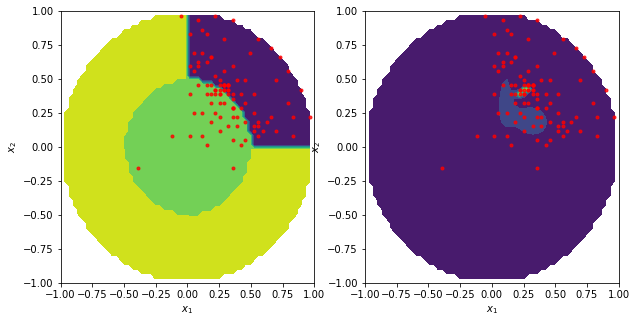

[1504 1963  810]
[1044 1787 1511]
[ 543  694 1090]
[ 599 1801 1690]
[1737 1517 1677]
28
[ 755  710 1202]


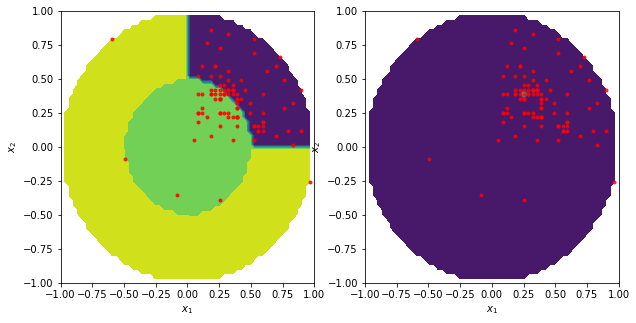

[1742 1038 1228]
[1214 1572  972]
[ 980 2012 1726]
[ 655 1225  879]
[1854 1692  810]
29
[1056 1911 1628]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


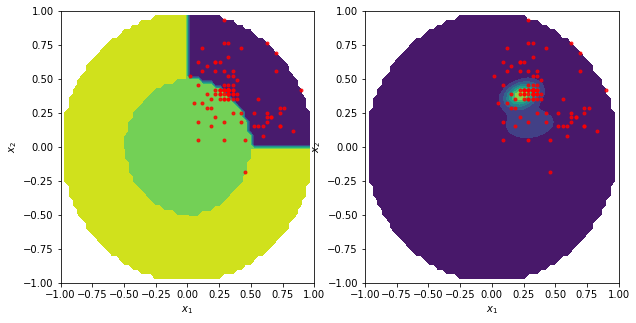

[1746 1272  593]
[1501 1337 1269]
[ 873 1899  880]
[ 699  876 1342]
[1276 1563  868]
30
[1093 1448 1565]


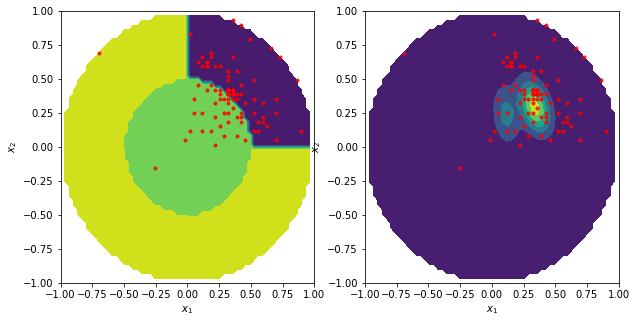

[1389 1262  651]
[ 702  997 1635]
[1687  595 1973]
[1230 1734 1225]
[ 868 2013 1967]
31
[ 542 1345 1054]


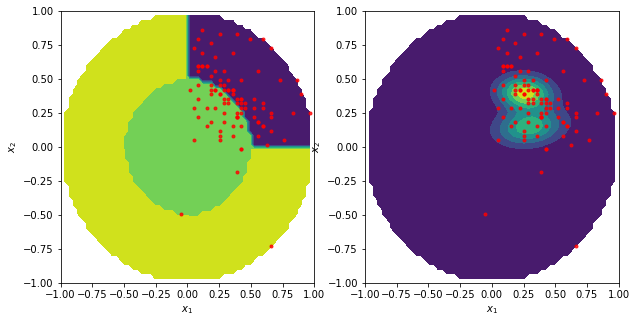

[1635  591 1049]
[ 984 2067 2028]
[1793 1396  873]
[1910 1492 1033]
[1289 1916 1029]
32
[ 881  939 1498]


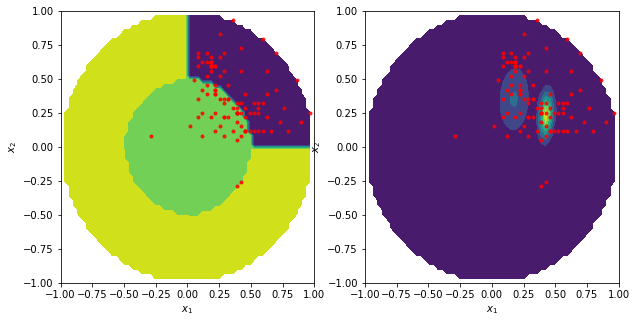

[1914  991 1107]
[2079 1045  919]
[1492 1859 2076]
[1087  923 1551]
[ 600 1207 1100]
33
[ 981  652 1325]


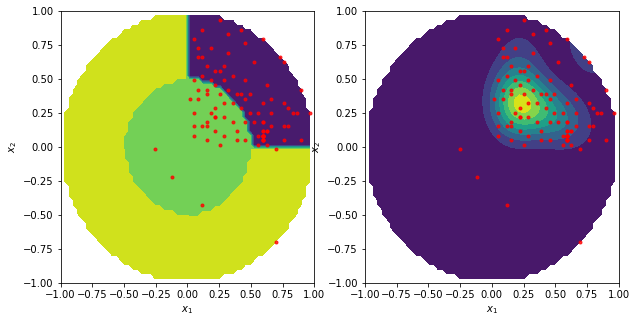

[ 650 2027 1097]
[1960 1285 1850]
[1225 1737 2071]
[1562 1619 1271]
[1792 1379 1847]
34
[ 705 1389 1514]


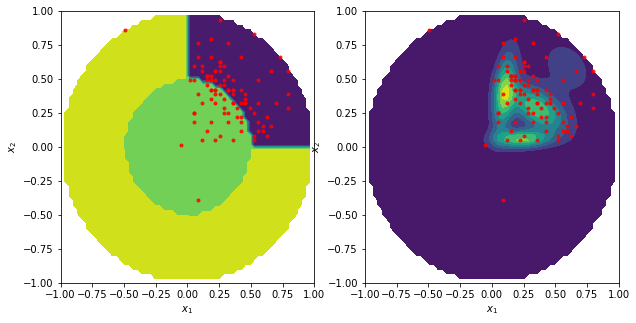

[ 764 1106 1726]
[1049 2076 1903]
[2023 1439  876]
[1962 1729 1796]
[ 702  917 1158]
35
[1855 1916 2122]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


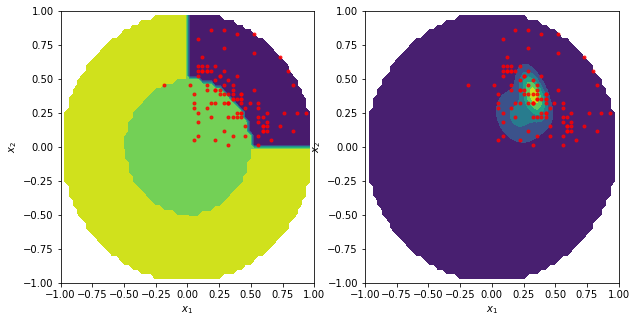

[ 984  814 1437]
[1908  698 1970]
[ 711  645 1405]
[ 880 1035 1029]
[1435 1569 1156]
36
[ 700 1853  762]


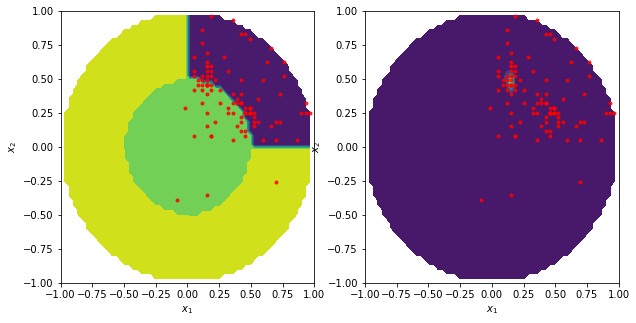

[1613 1171 1859]
[1114  765 1107]
[ 989  974 1343]
[ 645 1624 1277]
[ 652 1960 1277]
37
[1219 1864 1095]


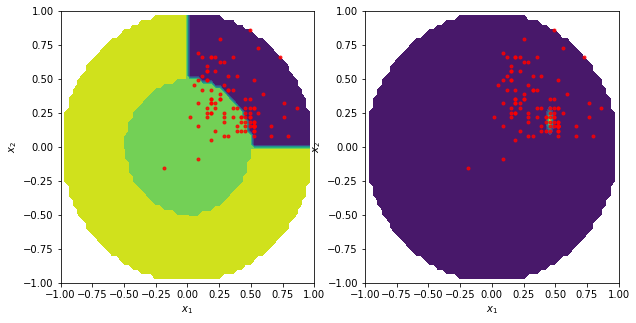

[1274  938 1726]
[1346 1282  803]
[1499 1038 1203]
[1512 1493 1203]
[1160 1055  649]
38
[1040  935 1342]


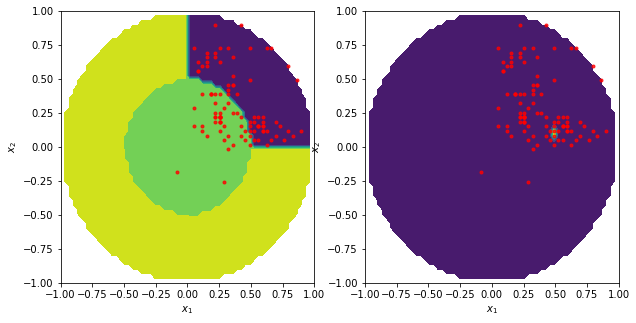

[ 758 1960 1567]
[ 860 1915 1569]
[1864 1800 1147]
[1114 1974 1228]
[ 700 1331 2022]
39
[1914 1557 1497]


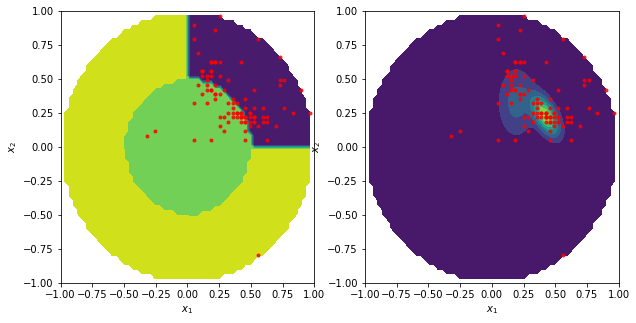

[1450  766 1793]
[ 808 1045 1622]
[1502 1458 1345]
[2180 1624 1735]
[ 987 1682 2133]
40
[1920 1975 1340]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


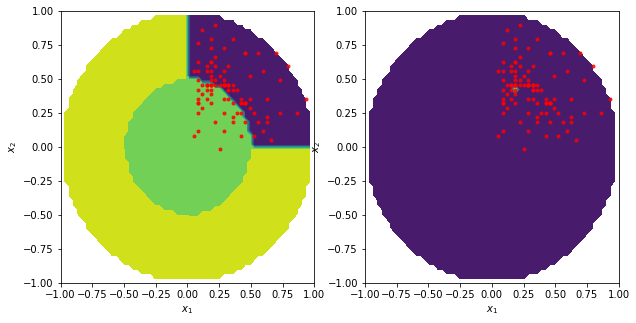

[1501 1169 1459]
[1400 1853  644]
[ 985 1108 1279]
[1445  647 2182]
[1850 1381  875]
41
[1786 1791  859]


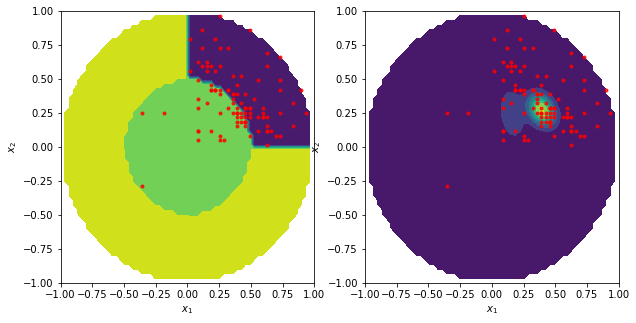

[1275 1514  978]
[1847 1218  858]
[2132 1039 1622]
[1519 1493 1445]
[1975  862 1861]
42
[1155  879  823]


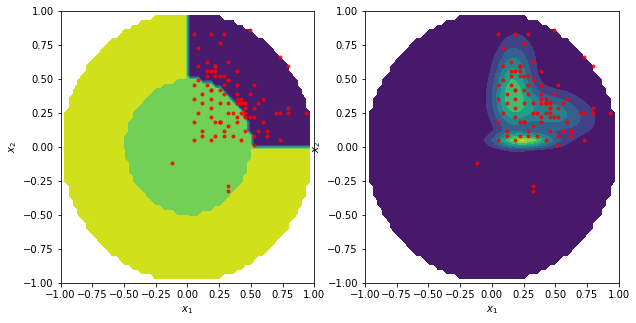

[1609 1970 1387]
[1215 1029 1915]
[1906  975 1751]
[1505  915  600]
[1345  653 1688]
43
[ 643 1208 1800]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


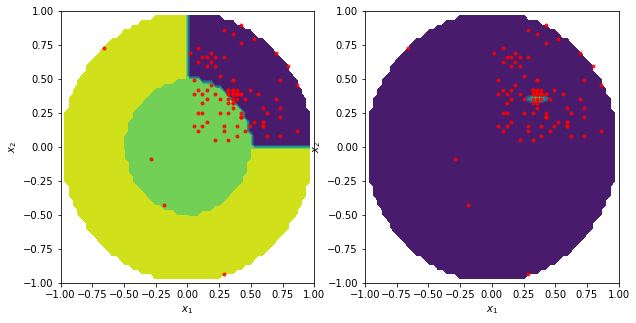

[1784 1149  763]
[1461 1447 1038]
[ 994 2014 1040]
[ 930 1260 2082]
[1567 2127 1278]
44
[ 759 1346  767]


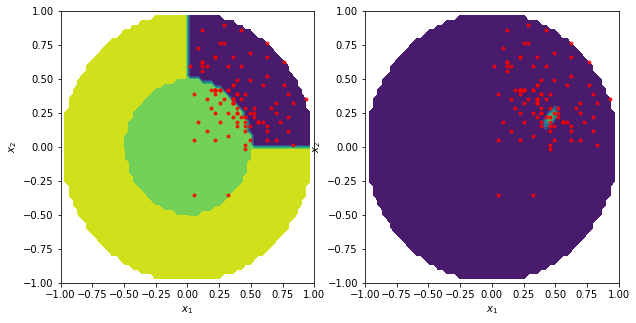

[1793  647  871]
[ 876 2078 1438]
[1330 1570 1029]
[2181 1111 1434]
[1626 1164 1381]
45
[1612 1030 1446]


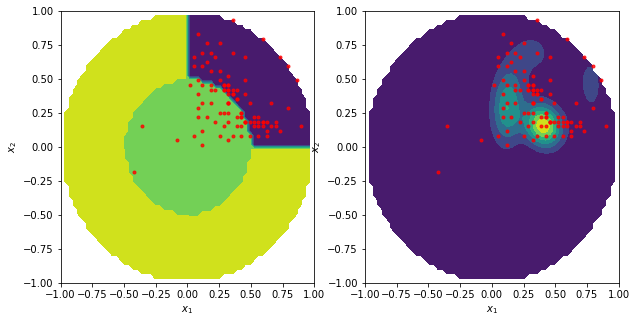

[2179 1624 1513]
[1268 1857  922]
[1265 1211 2127]
[1043 1399 1274]
[2080 1262 1858]
46
[ 706 1910 1211]


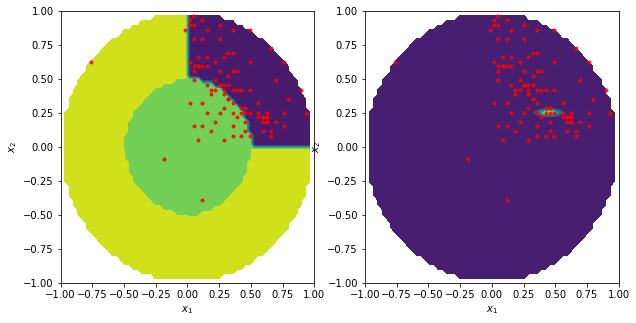

[1902 1459 1380]
[1794 1914  914]
[1680  656  876]
[1145 2019 1899]
[1738  749 2182]
47
[1517 1551 1346]


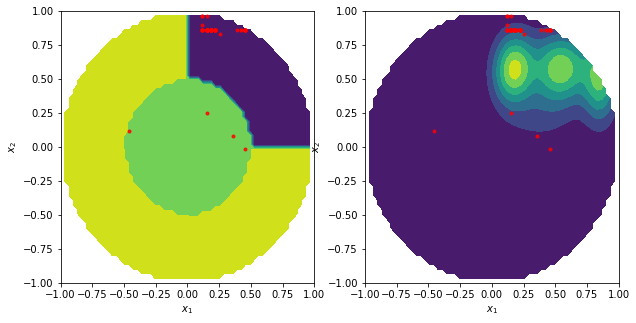

[1518 1741 1053]
[1091 2079 1342]
[1671 1964 1051]
[1793  756  644]
[ 877  748 1745]
48
[1157  939 1267]


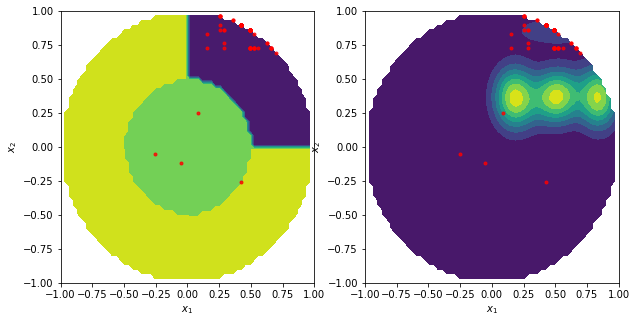

[1516 1035 1227]
[1460  592 2021]
[1515 1505  763]
[1105 2017 1214]
[1330 1168 1272]
49
[ 982  815 1436]


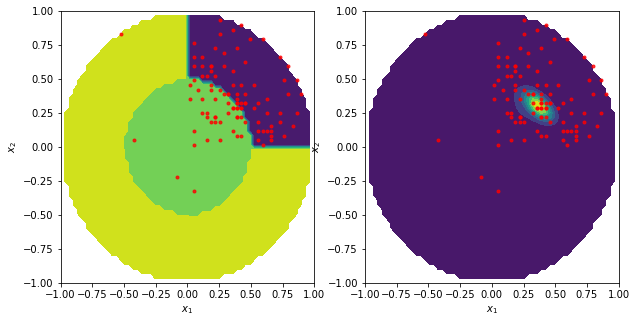

[1434 1399  976]
[ 710 1220  643]
[1554 1729 1906]
[1046 2071 1500]
[ 707 1619 2181]
50
[ 984 1729  698]


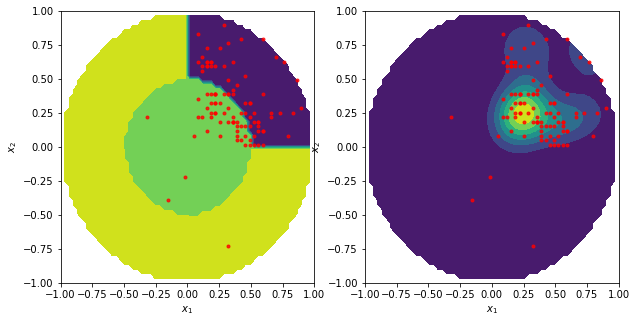

[ 701  591 1613]
[869 649 873]
[2178  651 2178]
[1688 1807  654]
[1627 1223 1389]
51
[1157 1035  805]


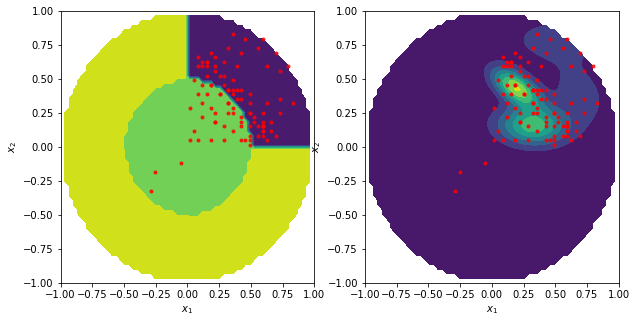

[1278 1223  934]
[1454 1095 1227]
[2129  807  598]
[1044 1740 1435]
[2017  710  653]
52
[1266 1806 1401]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


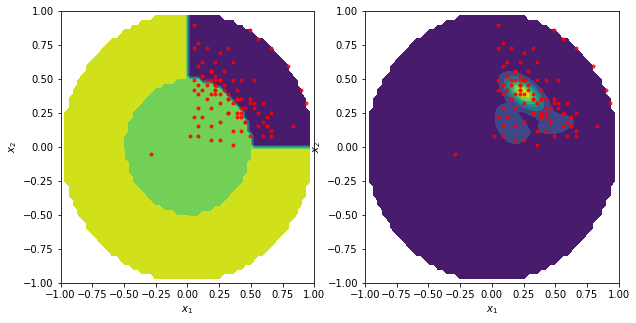

[1091  811 1505]
[1088 1049 1784]
[649 879 591]
[1577 1803  977]
[1434 1808  710]
53
[1446  709 1162]


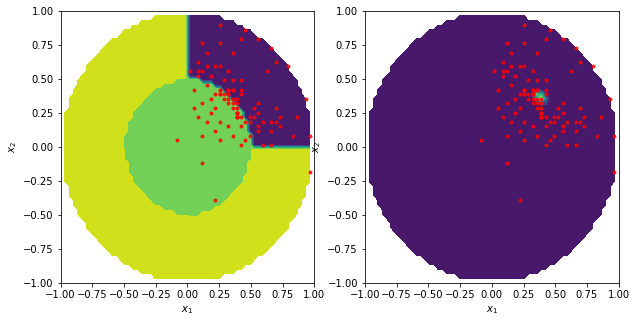

[ 709 1458 1336]
[ 920 1334  701]
[1151 1519  705]
[ 987 1399  643]
[1963 1737  593]
54
[1971 1286 1960]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


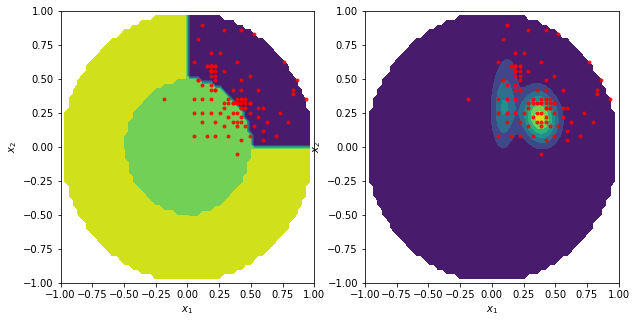

[1456 1578 1786]
[1045  929 1517]
[1749 1391 1746]
[1047 1746 1271]
[1043 1146 1973]
55
[ 545 1672 1615]


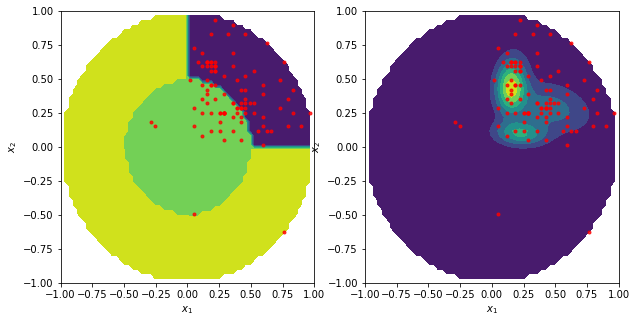

[ 924 1398 1376]
[2125 1631 1224]
[1053  752 1229]
[1454 1493 1203]
[1454 1401 1401]
56
[1090 1405 1448]


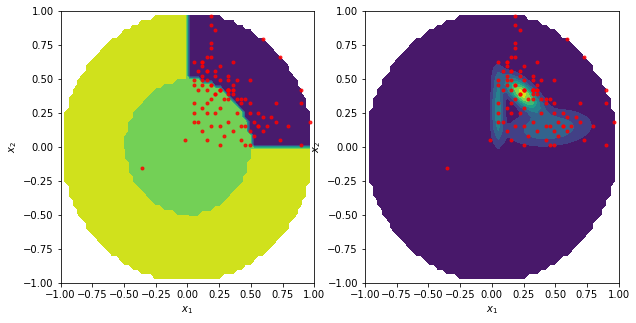

[1220  817 1229]
[1684  871  864]
[2020 1206 1692]
[1742 1229 1628]
[1397 1497 1499]
57
[1795 1441 2079]


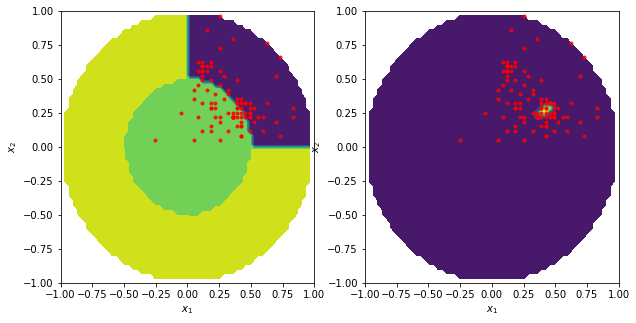

[1154 1966 1050]
[1052  876 1208]
[1860 2127 1682]
[1908 1744 1391]
[1035 1622 1446]
58
[1919 2024 1553]


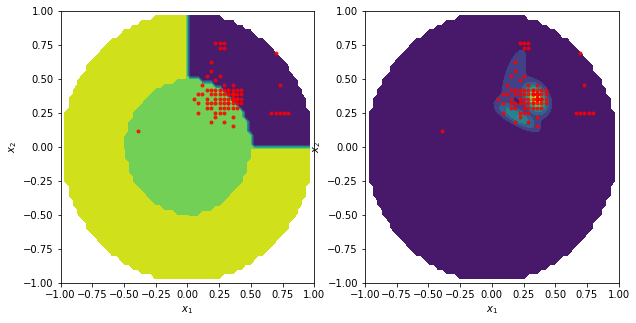

[2180  865  917]
[1508 1332  805]
[1563 1517 1558]
[ 647 2069  865]
[1516 1331  824]
59
[2076 1272 1504]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


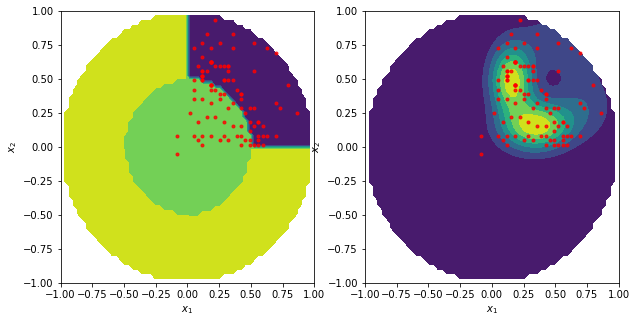

[1796 1668 1097]
[1172  809 1450]
[1447  820  647]
[1272  928 1108]
[1514 1971 1164]
60
[1318 1326 2025]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


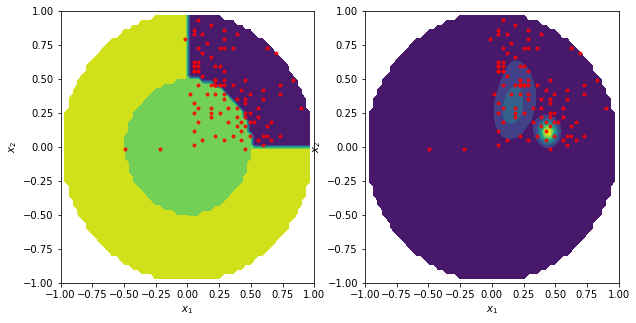

[1390 1518 1449]
[1088 1570 2018]
[1037 1105  805]
[2026 1171  813]
[1905 1450 2027]
61
[1557 1683 1901]


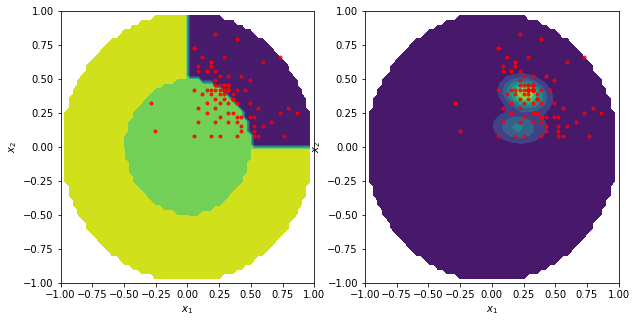

[1502 1030 1109]
[1670 1403 1565]
[1289 2013 1032]
[925 595 823]
[1260 1920 2074]
62
[2123 2133  644]


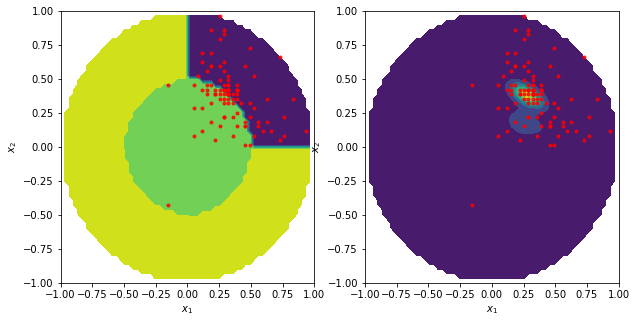

[1788  860  647]
[1731  868 1229]
[1226 1500 1963]
[2024  694  915]
[1209  973 1048]
63
[1158 1521 1965]


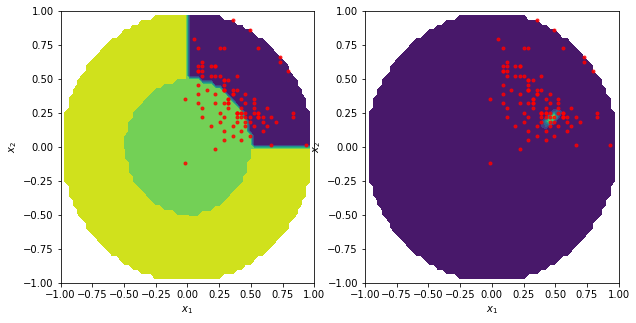

[ 869 1735 1441]
[1671 1521 1269]
[1495 1556 2015]
[1343 1795  651]
[1964 1671 1624]
64
[1848 1902 1436]


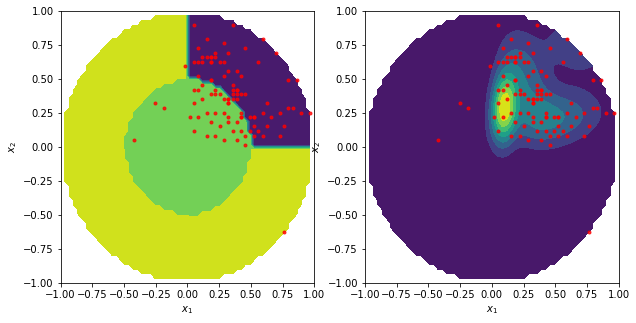

[ 818 2122 1270]
[1149 1435 1399]
[ 936 1672 1498]
[1960 2026 1739]
[ 867  866 1966]
65
[1970 1056 1331]


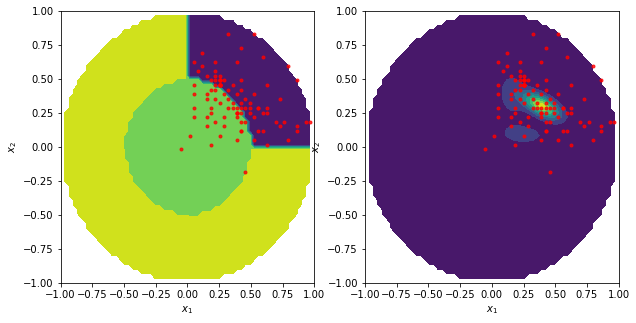

[1446 1055 1088]
[1347  859 2018]
[1046 1854 1957]
[1493 1693 1387]
[1746 1562  925]
66
[ 997 1789 1514]


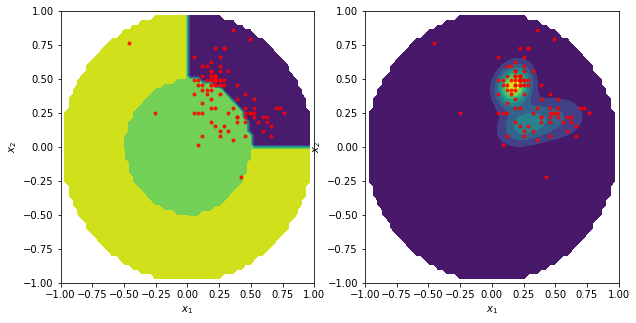

[1219  986  973]
[1283  806 1380]
[1104 1496 2025]
[1262 1802 1501]
[1796  823  642]
67
[ 651  598 1973]


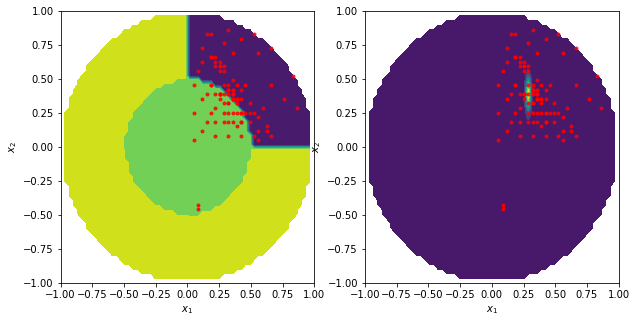

[1269 1334 1574]
[1520 1435 1576]
[ 983 1339  989]
[1969  914 1114]
[2014 1800 1567]
68
[1230 1850 1168]


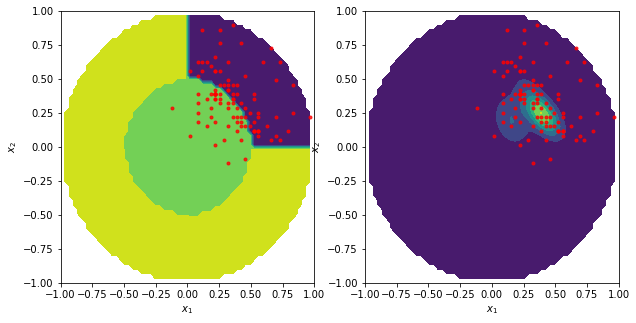

[1206 2014  601]
[1904  594 1730]
[1100 1269 1155]
[1733 1562 1336]
[1325 1517 1492]
69
[1789 1263 1154]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


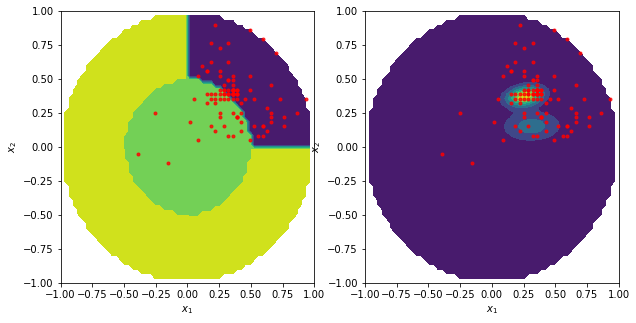

[1321 1393 1804]
[1971  643 1854]
[1495 1213 1670]
[ 650 1671 1226]
[1694  865 1573]
70
[ 871 1900  759]


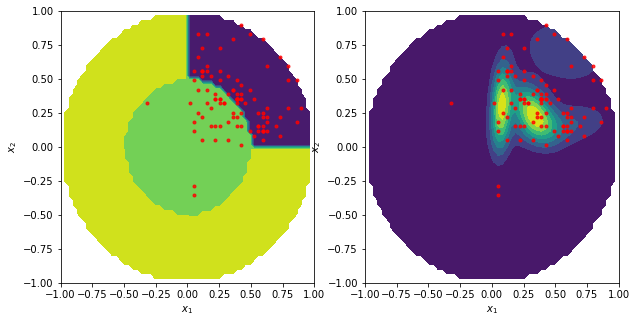

[2025 1165  824]
[ 711 1159 1861]
[1902 1274 1911]
[1112 1462 1680]
[1451  815 1963]
71
[1511 1107 1844]


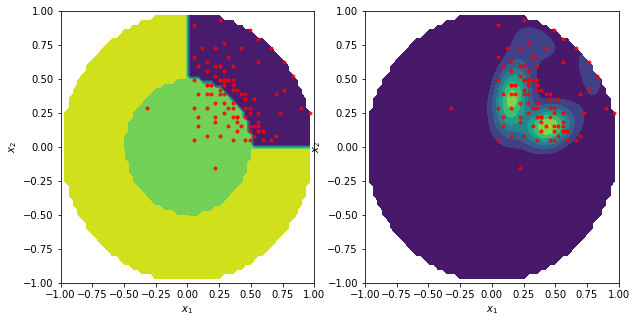

[1863  698 1675]
[1286 1440 1693]
[1728  758 1633]
[1504 1270  994]
[1395 1285  544]
72
[1678 1904 1263]


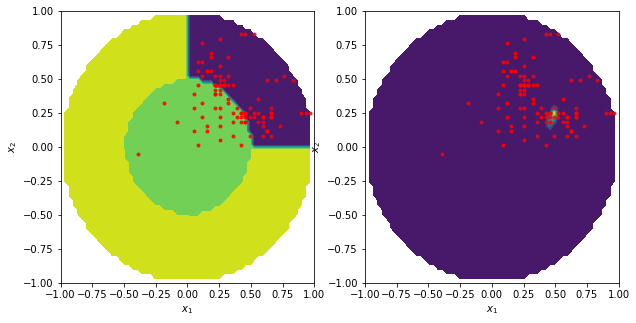

[2071 1676 1681]
[1387 1496  805]
[1040 2129 1742]
[1799  937 1846]
[1514 1398 1111]
73
[ 983 1905 1846]


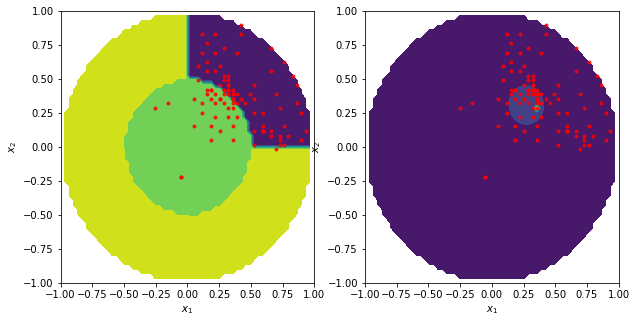

[ 807 1089 2179]
[1337 1046 1505]
[1614  755 1338]
[ 988 1957  879]
[1286 1563  696]
74
[1172  922 2075]


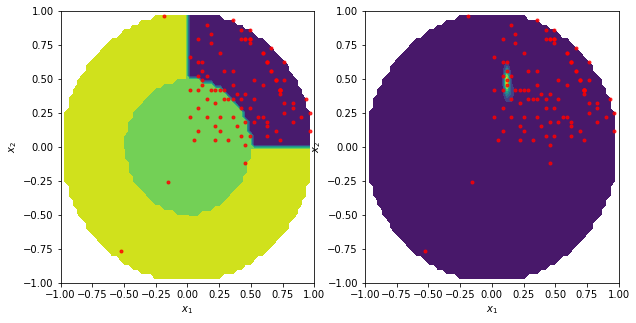

[ 804  924 1451]
[ 750 2016  544]
[1091 1631 1461]
[1851 1916 1035]
[1903 1495 1844]
75
[ 866 2021 1030]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


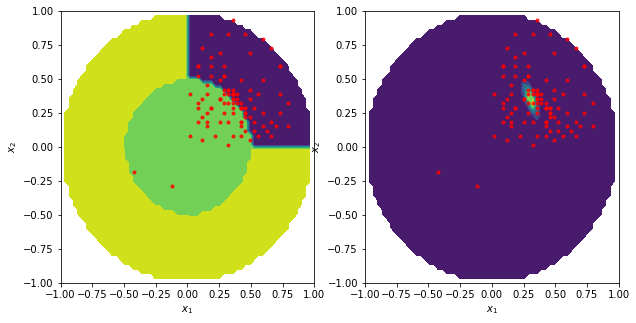

[1325 1786  858]
[ 762  708 1735]
[ 642 1434  881]
[1690 1149 1505]
[ 863 1726 1457]
76
[1164  930 1903]


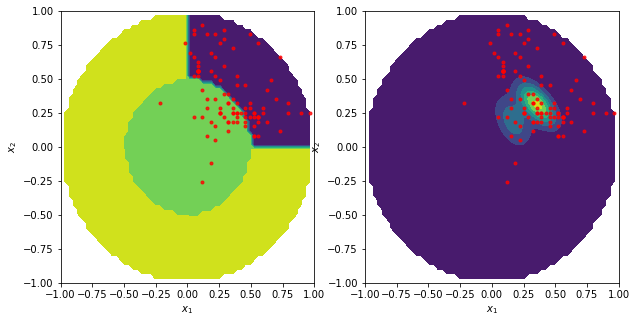

[ 595 1558  598]
[1280 1957 1963]
[1045 2126 1728]
[1105 1223  920]
[1858 2022 1516]
77
[1677 1147 1029]


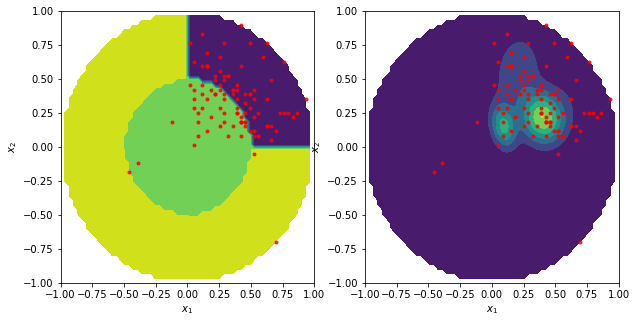

[1974 1447  805]
[1736  862  812]
[1094 1901  597]
[1572 1097  643]
[1669 1337 1171]
78
[1492 1493 2181]


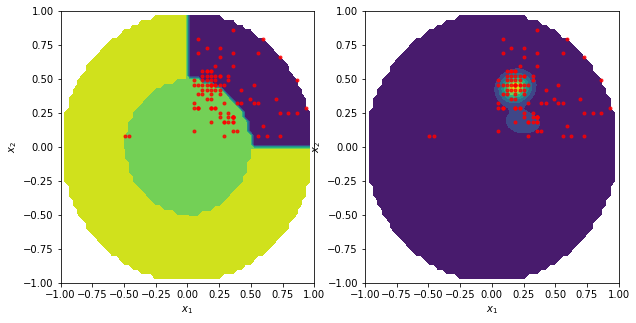

[1787  811 1575]
[ 925 1507  976]
[ 920  707 1164]
[1795 1444 1578]
[1227 2068 1153]
79
[1515 1741  702]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


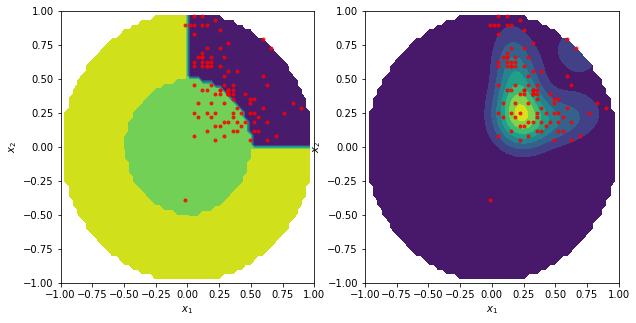

[1090  709 1731]
[2012  754  865]
[ 861 1681 1054]
[1401 1787 1610]
[1148 2076 1399]
80
[1208  924 1973]


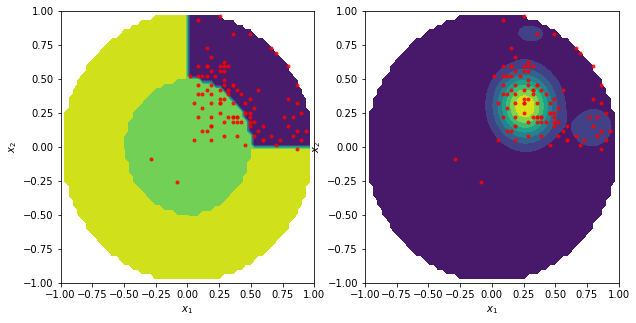

[ 877  652 1792]
[ 927  803 1735]
[ 766 2126 1694]
[ 593 1212  824]
[1444 1389 1971]
81
[ 705 1345 1857]


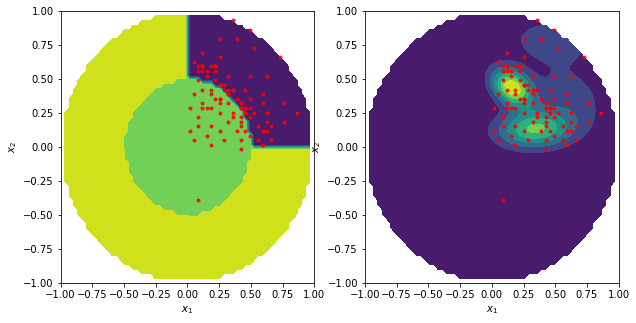

[1500 1968 1101]
[2022 1345 1265]
[ 976 1575 1171]
[1748  932 1517]
[2014 1279 1035]
82
[1161 2074 1688]


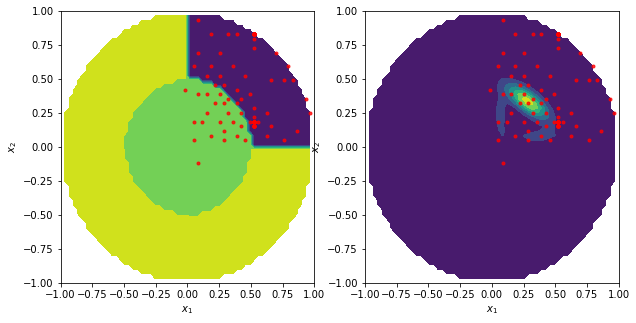

[ 935 2133 2081]
[1279 1503 1336]
[1632 1038 1262]
[ 938 1221 1090]
[1504  934 1678]
83
[1969 1864  816]


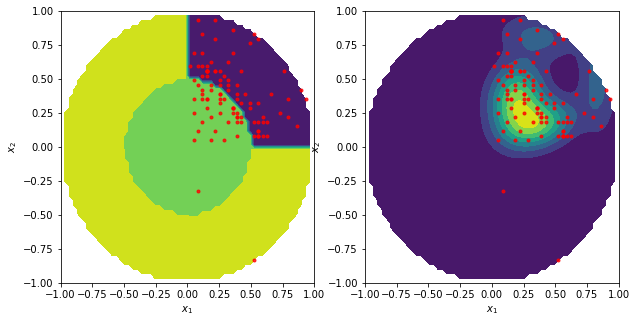

[1218 1101 1496]
[1504 1330 2133]
[2079 1851 1270]
[1391 1335 1444]
[1787  972 1630]
84
[ 868 2021 1635]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


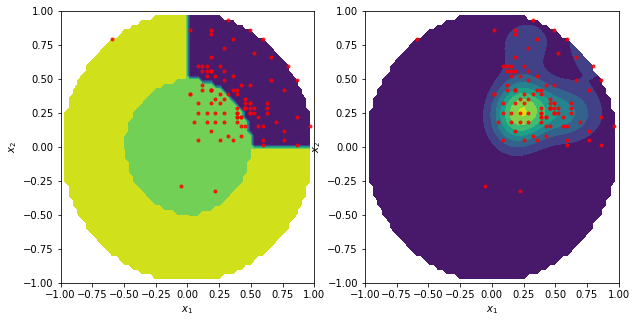

[2127 1615 2019]
[1390 1206 1343]
[1275  859 1628]
[1214 1396 1378]
[1496 1149 2178]
85
[ 592 1034 1260]


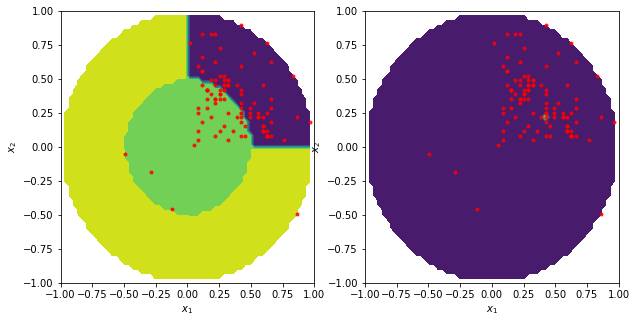

[1271  656 1913]
[ 760 2177  991]
[ 702 1213 1610]
[1792 1378 1669]
[ 994 1806  992]
86
[2067 1047  814]


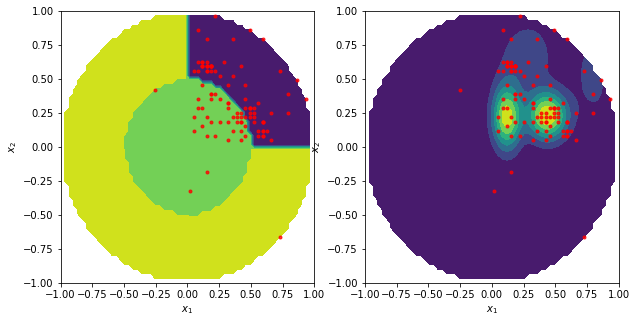

[1047  641 1566]
[1266  926 1964]
[1274 1161  709]
[1221 1279 1263]
[ 984 1266 1442]
87
[1441 1609  641]


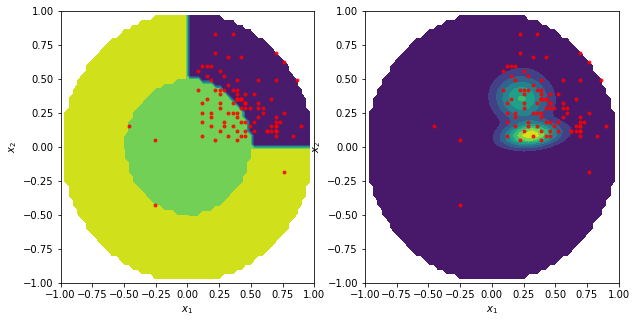

[1914 1449 1441]
[1215 2132 2082]
[1094 1799 1975]
[1915 1104  928]
[1166  980 1166]
88
[ 928 1381  932]


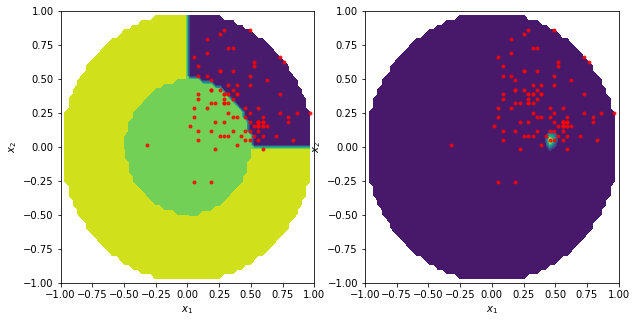

[1859 1859 1167]
[1614 1797  916]
[1147  543  809]
[1114  866 1794]
[ 923 1519  994]
89
[1054 2128 1230]


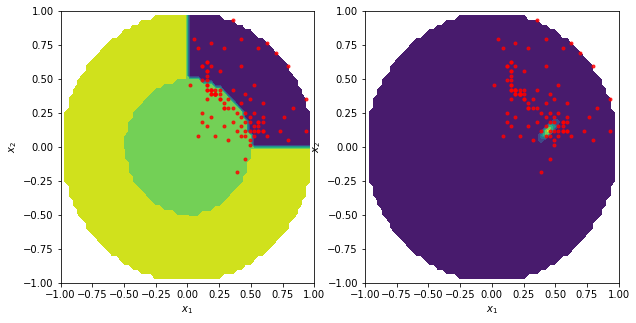

[921 699 702]
[2128 1165 1674]
[1785 1463 1501]
[1392 1899 1915]
[1325 1106  818]
90
[1404 1327  707]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


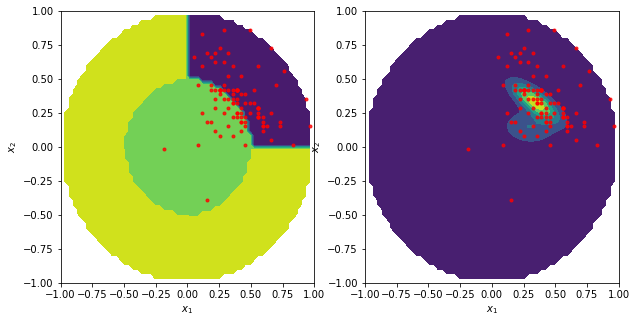

[ 992 1492 1050]
[2079 1054 2069]
[2132  868  927]
[1791 1172 1621]
[1336 1099 1849]
91
[1340 1095 1903]


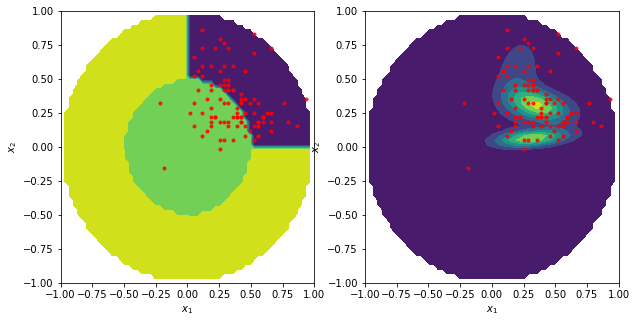

[1226 1963 1111]
[1442 1388 2071]
[1686 1040  807]
[ 649  982 1686]
[1853 1729 2123]
92
[1330 1393 1283]


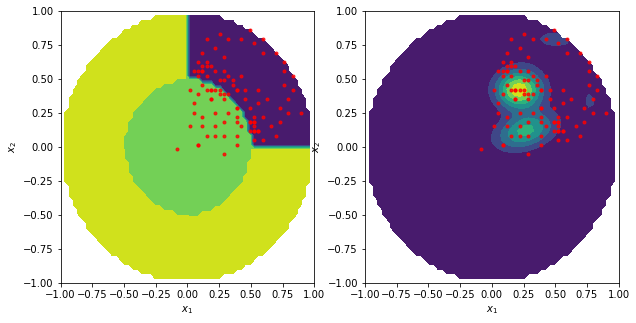

[1560 1333 1492]
[1277  871 1632]
[ 755 1101 1340]
[1388 1514 1675]
[1266 1572 1148]
93
[1681 1089  983]


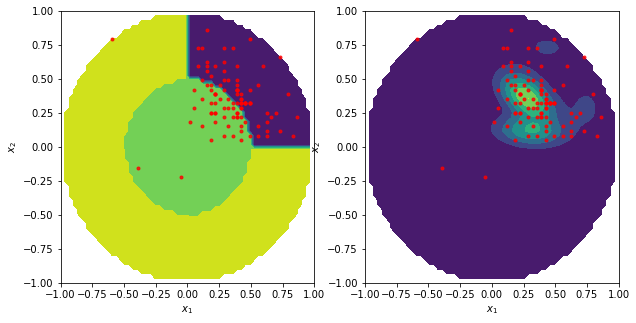

[ 601  992 1272]
[ 597 1221 1393]
[2129 1170  765]
[1446  919 1401]
[1434 1787  651]
94
[ 545 1219 1447]


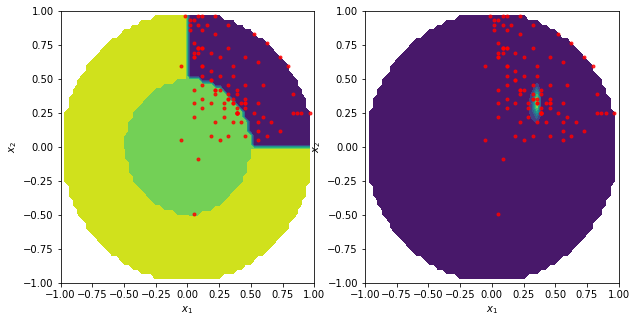

[1672 1269  934]
[1152 2018 1791]
[1727 1286  803]
[1229  995 1619]
[1901 1439  822]
95
[1676 1847 1222]


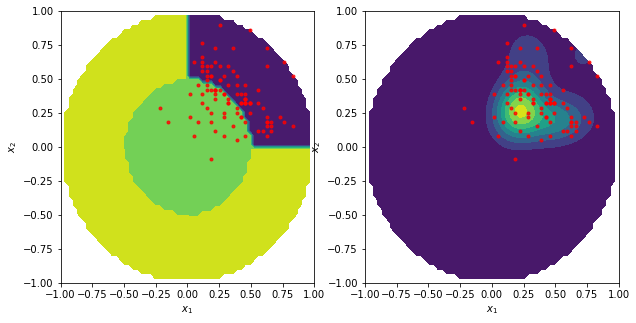

[ 925  758 1111]
[1268 1964 2180]
[1049 2124 1213]
[ 920  703 1786]
[1089 1670 1962]
96
[1799 1286  758]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/mixture/_base.py:148: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  random_state=random_state).fit(X).labels_


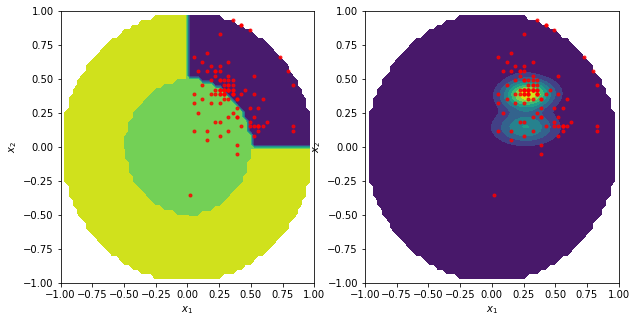

[1559  594 1800]
[1684 2016 2131]
[1203  590 2014]
[ 989  709 2068]
[ 878 1161 1630]
97
[ 598 1970 1167]


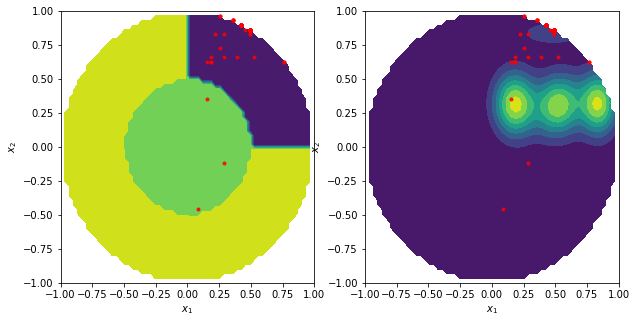

[ 708 1634  869]
[1453 1202 1749]
[1911  762 1111]
[1851 1554 1046]
[1261  876 1091]
98
[1046  997 1742]


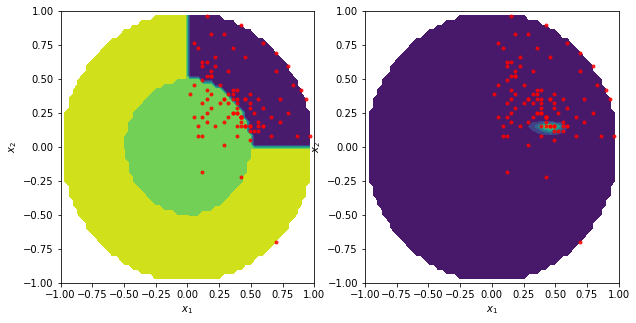

[ 930 1911 1743]
[992 860 803]
[ 656 1965 1502]
[1689 1805 2079]
[1150 1612  817]
99
[ 924  876 1688]


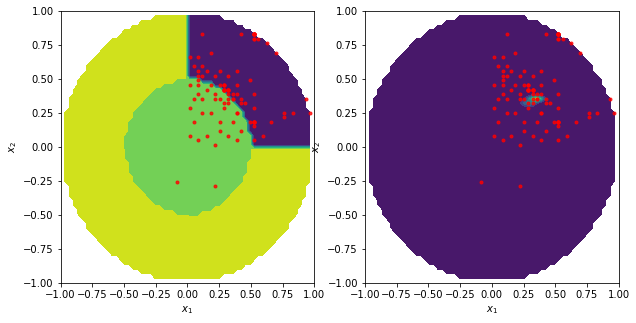

[1692  986 1330]
[1908 1215 1667]
[1398 1208  695]
[1562 1751 1693]
[1630 1287 1673]
(100, 100) (100, 100) (100, 100) (100, 100) (100, 100) (100, 100) (100, 102, 2) (100, 102, 2) (100, 102, 2) (100, 102, 2) (100, 102, 2) (100, 102, 2) (100, 60, 60)


In [6]:
model = run_simulations(Y_data, xs, sigma, T, MC_samples, XX, YY, Y_data_plot, nn, delta_control)
regrets_LCB, regrets_LCB_v, regrets_mean, regrets_TS, regrets_EI, regrets_LW_LCB, \
X_LCB, X_LCB_v, X_mean, X_TS, X_EI, X_LW_LCB, Weights_LW_LCB = model.train()

np.save("regrets_LCB", regrets_LCB)
np.save("regrets_LCB_v", regrets_LCB_v)
np.save("regrets_mean", regrets_mean)
np.save("regrets_TS", regrets_TS)
np.save("regrets_EI", regrets_EI)
np.save("regrets_LW_LCB", regrets_LW_LCB)

np.save("X_LCB", X_LCB)
np.save("X_LCB_v", X_LCB_v)
np.save("X_mean", X_mean)
np.save("X_TS", X_TS)
np.save("X_EI", X_EI)
np.save("X_LW_LCB", X_LW_LCB)

np.save("Weights_LW_LCB", Weights_LW_LCB)

